# Healthcare System Model

This notebook provides a front-end to an example healthcare model, implemented using Python, Pandas and Dask. The model comprises:

+ Importing historic activity data, population growth forecasts and assumptions.

+ Forecasting future activity based upon historic activity and population growth.

+ Transforming the business model by moving activity from acute hospitals into the community.

In [1]:
import plotly.express as px

## Explore input data

Historical data and assumptions are contained within text files (CSV) in the Import_data directory. It is also possible to import data from other sources that are supported by Pandas, such as databases. To view the data, an instance of the class containing the data needs to be created, this will then create the execution graph based upon that nodes precedents. Creating an instance of the class does not load the data, to do that the `compute()` method on the data attribute must be called. The table below shows the annual change in population by age band for each of the forecast year (rounded to three decimal places).

In [2]:
from dask_modelling_example import population_data
population_data().data.compute().head().round(3)

,age_band,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031
0,A.000-004,-0.003,-0.008,0.000,-0.001,-0.001,-0.010,-0.008,-0.006,-0.005,-0.004,-0.003
1,B.005-009,0.002,0.000,0.002,0.011,0.011,-0.025,-0.019,-0.012,-0.010,-0.010,-0.009
2,C.010-014,0.024,0.018,0.005,0.017,0.017,-0.009,-0.023,-0.019,-0.021,-0.019,-0.023
3,D.015-019,0.010,0.032,0.036,-0.001,-0.001,0.024,0.021,0.001,0.002,-0.004,-0.008
4,E.020-024,-0.019,-0.024,-0.010,-0.009,-0.009,0.017,0.030,0.033,0.023,0.023,0.021


If the docstring is available, then a description of the data can also be printed.

In [3]:
print(population_data().__doc__)

Forecast for the annual rate of population growth by five year age band.

    Population forecasts are mid-year estimates by 5-year age band (up to 85+).

    Inherits from base class loader

    Attributes:
        data (pd.DataFrame): Forecast of population by locality, age and service line.
    


The historic activity for acute hospitals and community can also be printed and plotted.

In [4]:
from dask_modelling_example import acute_forecast, community_forecast
acute_forecast().data.compute().head()

,domain,hospital_name,region,service_line,sex,age_band,year,activity
0,acute,Hospital one,North,Cardiology,Female,A.000-004,2020,43807.0
1,acute,Hospital one,North,Cardiology,Female,B.005-009,2020,26608.0
2,acute,Hospital one,North,Cardiology,Female,C.010-014,2020,33975.0
3,acute,Hospital one,North,Cardiology,Female,D.015-019,2020,33956.0
4,acute,Hospital one,North,Cardiology,Female,E.020-024,2020,32340.0


In [5]:
cf = community_forecast().data.compute()
cf.head()

,domain,hospital_name,region,service_line,sex,age_band,year,activity
0,community,Hospital one,North,Cardiology,Female,A.000-004,2020,219034.0
1,community,Hospital one,North,Cardiology,Female,B.005-009,2020,133041.0
2,community,Hospital one,North,Cardiology,Female,C.010-014,2020,169877.0
3,community,Hospital one,North,Cardiology,Female,D.015-019,2020,169779.0
4,community,Hospital one,North,Cardiology,Female,E.020-024,2020,161700.0


In [6]:
px.bar(
    cf.groupby(["year", "hospital_name"], as_index=False).agg({"activity":"sum"}),
    x="year",
    y="activity",
    color="hospital_name",
    height=720,
    width=1280,
    title="Total annual activity by acute hospital"
)

In [7]:
px.bar(
    cf.groupby(["year", "service_line"], as_index=False).agg({"activity":"sum"}),
    x="year",
    y="activity",
    color="service_line",
    height=720,
    width=1280,
    title="Total annual activity by service line"
)

## Results of the model

The results of the model are obtained by computing the final node in the execution graph.

In [8]:
from dask_modelling_example import business_transform
bt = business_transform().data.compute()
bt.head().round(0)

,hospital_name,region,service_line,sex,age_band,year,acute_activity,community_activity,activity_shift_to_community,revised_acute_activity,revised_community_activity
0,Hospital one,North,Cardiology,Female,A.000-004,2020,43807.0,219034.0,0.0,43807.0,219034.0
1,Hospital one,North,Cardiology,Female,B.005-009,2020,26608.0,133041.0,0.0,26608.0,133041.0
2,Hospital one,North,Cardiology,Female,C.010-014,2020,33975.0,169877.0,0.0,33975.0,169877.0
3,Hospital one,North,Cardiology,Female,D.015-019,2020,33956.0,169779.0,0.0,33956.0,169779.0
4,Hospital one,North,Cardiology,Female,E.020-024,2020,32340.0,161700.0,0.0,32340.0,161700.0


In [9]:
px.line(
    bt.groupby(["year"], as_index=False).sum(),
    x="year",
    y=["acute_activity", "community_activity", "revised_acute_activity", "revised_community_activity"],
    height=720,
    width=1280,
    labels={"value":"Total Annual Activity", "year": "Year"},
    title="Impact on annual activity of moving activity into the community"
)

## Visualising results

Executing `visualize()` method on the final node provides a visualisation of the execution graph.

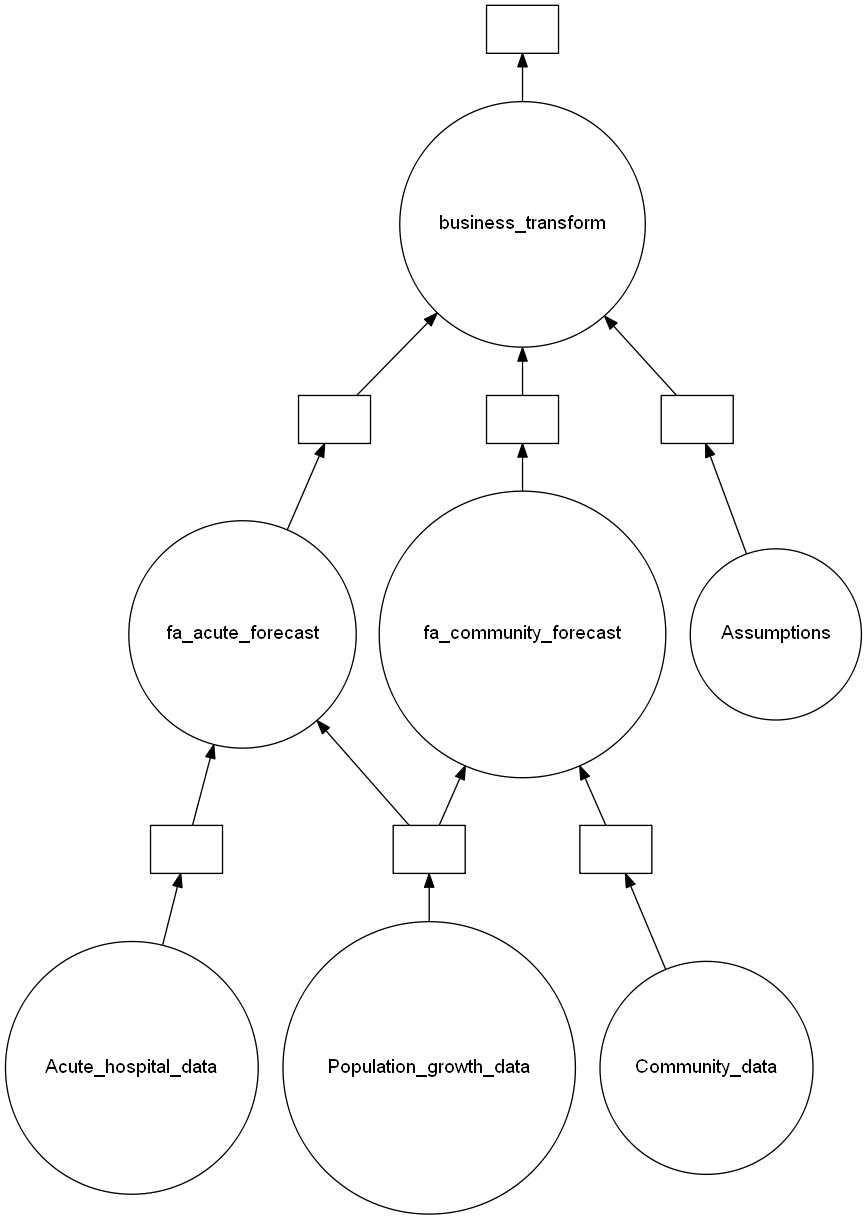

In [10]:
business_transform().data.visualize()